## Neural Style Transfer

## Задача


Объединить две картинки, используя одну из них в качестве фильтра.

In [1]:
!pip install torch torchvision

## Загрузка VGG19

Для решения задачи воспользуемся параметрами из предобученной VGG19.

In [2]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained=True)
print(vgg)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 108MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(dev)

cuda


In [6]:
vgg.to(dev)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Предобработка изображений

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [7]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size=500):
  image = Image.open(img_path).convert("RGB")
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
  ])
  image = img_transforms(image)
  image = image.unsqueeze(0) # (3, 224, 224) -> (1, 3, 224, 224)

  return image

In [10]:
content_preprocess = preprocess("/content/light.jpg")
style_preprocess = preprocess("/content/dark.jpg")

content_preprocess = content_preprocess.to(dev)
style_preprocess = style_preprocess.to(dev)

print(f"Content shape {content_preprocess.shape}")
print(f"Style shape {style_preprocess.shape}")

Content shape torch.Size([1, 3, 500, 500])
Style shape torch.Size([1, 3, 500, 500])


## Преобразование вектора в картинку

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.numpy()
  image = image.squeeze(0) # (1, 3, 224, 224) -> (3, 224, 224)
  image = image.transpose(1, 2, 0) # (3, 224, 224) -> (224, 224, 3)
  image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
  image = image.clip(0,1)

  return image


In [12]:
content_deproc = deprocess(content_preprocess)
style_deproc = deprocess(style_preprocess)

print(f"Deprocess content: {content_deproc.shape}")
print(f"Deprocess style: {style_deproc.shape}")

Deprocess content: (500, 500, 3)
Deprocess style: (500, 500, 3)


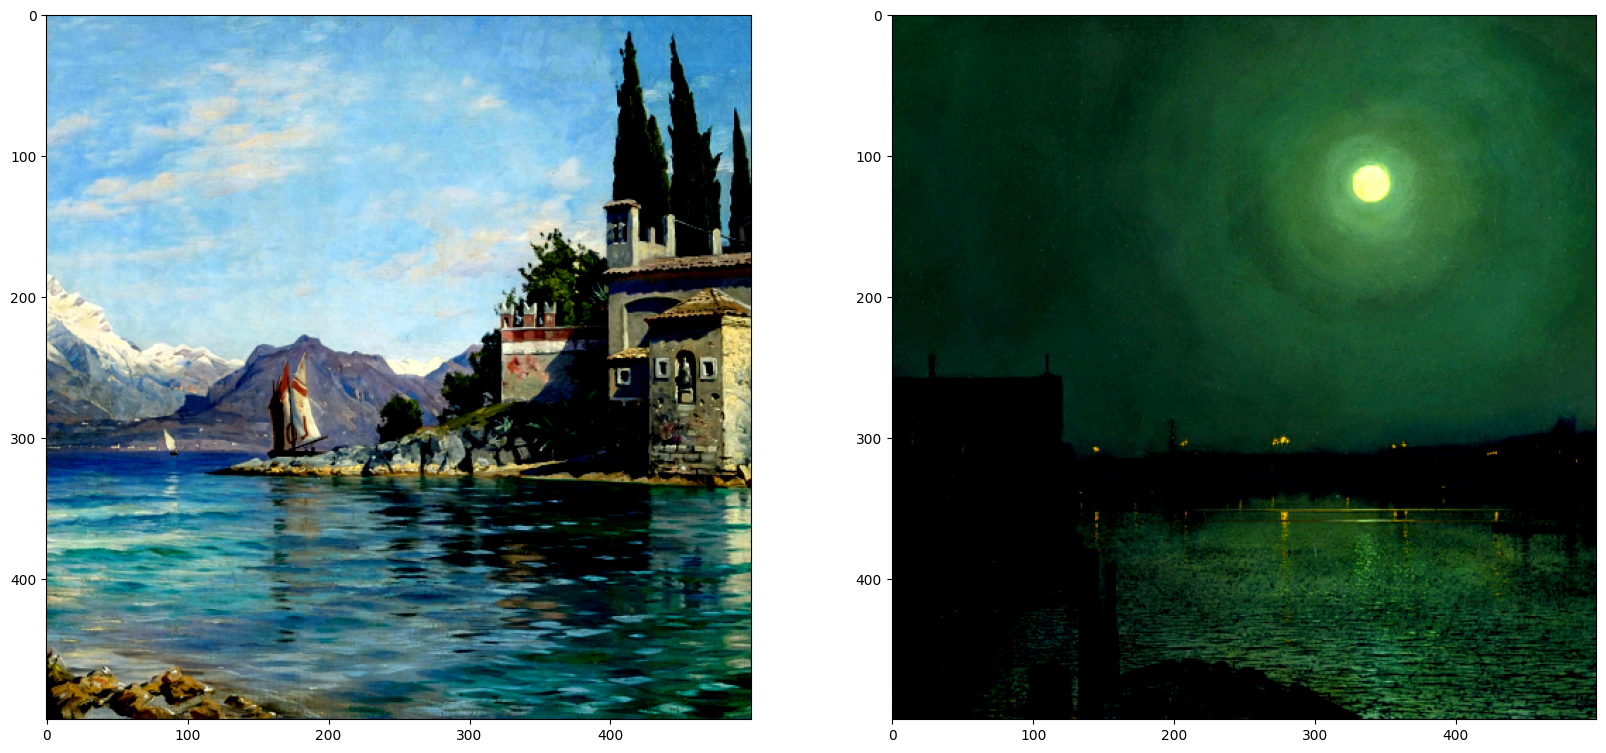

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_deproc)
ax2.imshow(style_deproc);

## Извлечение признаков из картинки и стиля, построение матрицы Грама

In [14]:
def get_features(image, model):
  layers = {
      "0": "conv1_1",  # see representaion.png
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2", #content_feature
      "28": "conv5_1"
  }

  x = image
  Features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

  return Features

In [15]:
content_features = get_features(content_preprocess, vgg)
style_features = get_features(style_preprocess, vgg)

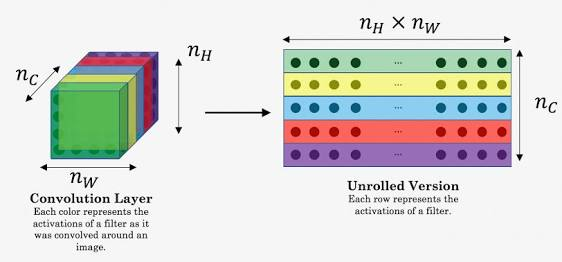

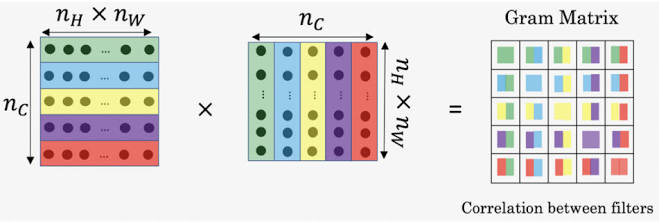

In [16]:
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [17]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

## Создание функций потерь для картинки и стиля

In [18]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [19]:
style_weights = {
    "conv1_1": 1.0,
    "conv2_1": 0.75,
    "conv3_1": 0.75,
    "conv4_1": 0.75,
    "conv5_1": 0.75
}

In [20]:
def style_loss(style_weights, target_fs, style_grams):
  loss = 0
  for layer in style_weights:
    target_feature = target_fs[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    b, c, h, w = target_feature.shape
    layer_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [21]:
target = content_preprocess.clone().requires_grad_(True).to(dev)
target_f = get_features(target,vgg)
print(f"Content loss: {content_loss(target_f['conv4_2'], content_features['conv4_2'])}")
print(f"Style loss: {style_loss(style_weights, target_f,style_grams)}")

Content loss: 0.0
Style loss: 95.34444427490234


## Обучение модели

In [22]:
from torch import optim

optimizer = optim.Adam([target],lr=0.003)

alpha = 1.0
beta = 1e5
epochs = 4000
show_every = 500

In [23]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

In [24]:
results = []

for i in range(epochs):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f["conv4_2"], content_features["conv4_2"])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss,s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at Epoch {i}: {t_loss}")
    results.append(deprocess(target.detach()))

Total loss at Epoch 0: 9534444.0
Total loss at Epoch 500: 384029.96875
Total loss at Epoch 1000: 222829.453125
Total loss at Epoch 1500: 151766.46875
Total loss at Epoch 2000: 108767.3125
Total loss at Epoch 2500: 80535.578125
Total loss at Epoch 3000: 61319.4921875
Total loss at Epoch 3500: 47248.02734375


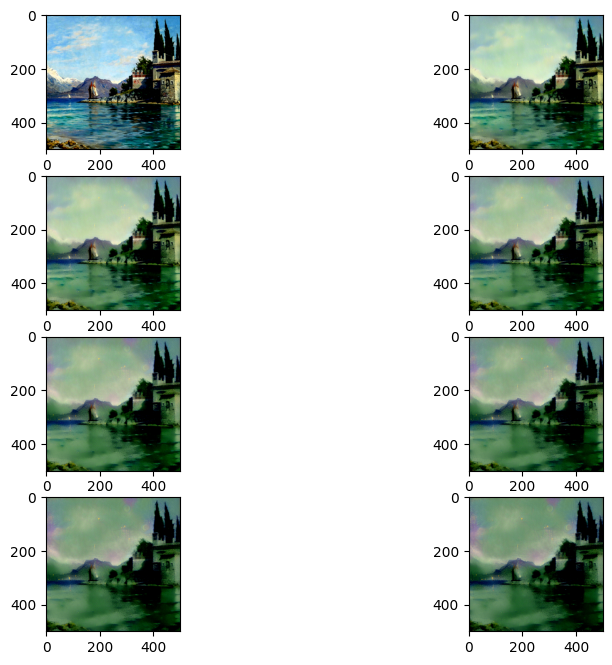

In [25]:
plt.figure(figsize=(10,8))
for i,_ in enumerate(results):
  plt.subplot(4,2, i+1)
  plt.imshow(results[i])
plt.show()

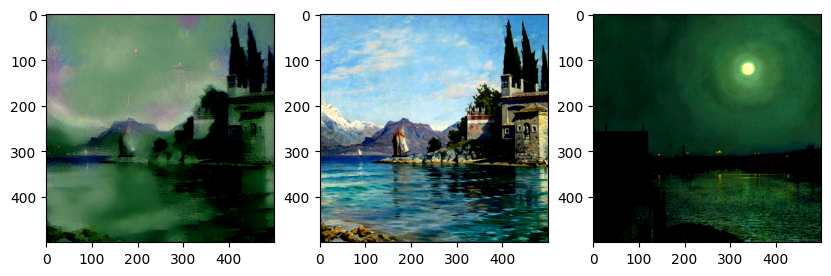

In [27]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocess)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)
ax3.imshow(style_deproc);

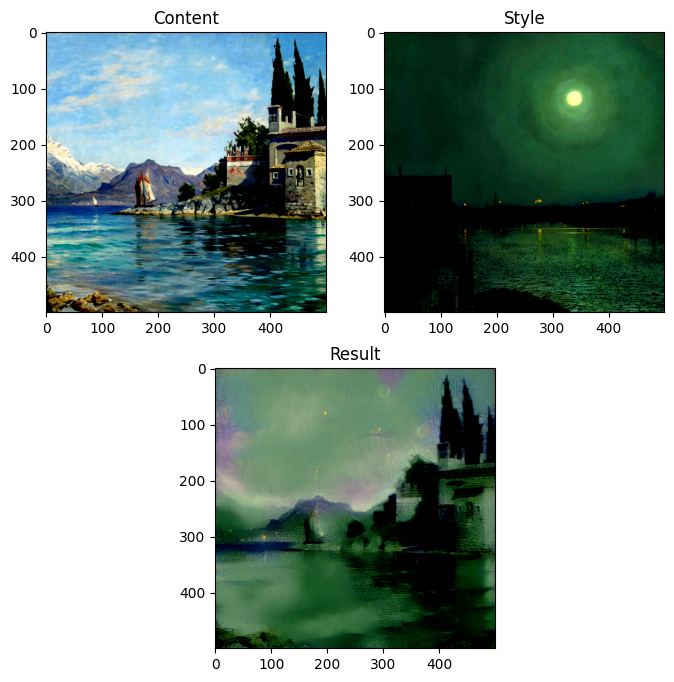

In [40]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.set_title("Content")
ax1.imshow(content_copy)

ax2.set_title("Style")
ax2.imshow(style_deproc)

ax3.set_title("Result")
ax3.imshow(target_copy)

plt.savefig("result.jpg");